In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from scipy.optimize import root
import h5py
import os
import itertools
import gvar as gv
import lsqfit as fit

n_boot = 200
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from pytools import *
from formattools import *
from plottools import *
style = styles['notebook']

In [2]:
# utility functions for plotting
h = lambda p : np.sum(p ** 4) / (square(p) ** 2)
hn = lambda p, n : np.sum(p**n / square(p)**(n//2))
cols = ['k', 'tab:brown', 'b', 'g', 'y', 'tab:orange', 'r', 'm']
cuts = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
patches = [mpatches.Patch(color = cols[ii], label = '$h(p) < ' + str(cuts[ii]) + '$') for ii in range(len(cols))]
def color_fn(hp):
    for ii in range(len(cols)):
        if hp < cuts[ii]:
            return cols[ii]
    return cols[-1]
def plot_h4_breaking(apsq_list, Zmu, Zsigma, ylabel, color_list, title = None, plt_geom = (1, 1), fsize = (10, 6), \
                     leg_loc = (1., 1.), plot_mu = False):
    with sns.plotting_context('talk'):
        if plt_geom == (1, 1):
            plt.figure(figsize = (10, 6))
            for ii in range(len(apsq_list)):
                plt.errorbar(apsq_list[ii], Zmu[ii], Zsigma[ii], fmt = '.', c = color_list[ii])
            if plot_mu:
                plt.xlabel('$\mu^2$ ($\\mathrm{GeV}^2$)')
            else:
                plt.xlabel('$(ap)^2$')
            #plt.xlim((0, 7))
            plt.ylabel(ylabel)
            if title:
                plt.title(title)
            plt.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.show()
        else:
            fig, ax = plt.subplots(plt_geom[0], plt_geom[1], figsize = fsize)
            for i in range(plt_geom[0]):
                for j in range(plt_geom[1]):
                    tidx = j * plt_geom[0] + i
                    if tidx >= Zmu.shape[0]:
                        continue
                    for pidx in range(len(apsq_list_sub)):
                        ax[i, j].errorbar(apsq_list_sub[pidx], Zmu[tidx, pidx], Zsigma[tidx, pidx], fmt = '.', \
                                          c = color_list[pidx])
                    if plot_mu:
                        ax[i, j].set_xlabel('$\mu^2$ ($\\mathrm{GeV}^2$)')
                    else:
                        ax[i, j].set_xlabel('$(ap)^2$')
                    ax[i, j].set_ylabel(ylabel)
                    #ax[i, j].set_xlim((0, 7))
                    if title:
                        ax[i, j].set_title(title + ', comp ' + str(tidx) + ' in RI/MOM')
            fig.legend(handles = patches, bbox_to_anchor = leg_loc)
            plt.tight_layout()
            plt.show()

### Load data in $\overline{\mathrm{MS}}$

To run on RI'/MOM data, use path '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/Zqq_114141.h5'. Data is run on 220 configurations.

In [17]:
k_list

array([[1, 1, 1, 1],
       [1, 1, 1, 2],
       [1, 1, 1, 3],
       ...,
       [6, 6, 6, 4],
       [6, 6, 6, 5],
       [6, 6, 6, 6]])

In [3]:
L, T = 12, 24
# h_cut = 0.27
# h_cut = 0.35
h_cut = 0.3
h6_cut = 10
h8_cut = 10
ksq_cut = 12
psq_cut_min = 2
psq_cut_max = 15
# h_cut = 0.27
# h6_cut = 10
# h8_cut = 10
path = '/Users/theoares/Dropbox (MIT)/research/gq_mixing/analysis_output/ZMSbar_114141.h5'
Lat = Lattice(L, T)
f = h5py.File(path, 'r')
k_list = f['momenta'][()]
RqqZqq = np.real(f['RqqZqq'][()])
RqgZqq = np.real(f['RqgZqq'][()])
f.close()

p_list = np.array([Lat.to_linear_momentum(k) for k in k_list])
plat_list = np.array([Lat.to_lattice_momentum(k) for k in k_list])
apsq_list = np.real(np.array([square(p) for p in p_list]))

In [4]:
eps = 2.0    # radius of "democracy ball"
max_n = 5

In [5]:
# subset k_idxs

# standard cut on h4, also cutting on h6 and h8
kidx = 0
k_subset_idxs = []
for kidx, k in enumerate(k_list):
    p = p_list[kidx]
    apsq = apsq_list[kidx]
    if h(p) <= h_cut and hn(p, 6) <= h6_cut and hn(p, 8) <= h8_cut and apsq >= psq_cut_min and apsq <= psq_cut_max:
        k_subset_idxs.append(kidx)
k_subset_idxs = np.array(k_subset_idxs)

# kidx = 0
# k_subset_idxs = []
# for kidx, k in enumerate(k_list):
#     p = p_list[kidx]
#     apsq = apsq_list[kidx]
#     for n in range(2, max_n + 1):
#         if hn(p, 2*n) > eps * hn(k_list[0], 2*n):
#             break
#         if n == max_n and apsq >= psq_cut_min and apsq <= psq_cut_max:
#             k_subset_idxs.append(kidx)
# k_subset_idxs = np.array(k_subset_idxs)

In [6]:
k_list_sub = k_list[k_subset_idxs]
p_list_sub = p_list[k_subset_idxs]
plat_list_sub = plat_list[k_subset_idxs]
apsq_list_sub = apsq_list[k_subset_idxs]
RqqZqq_sub = RqqZqq[:, k_subset_idxs]
RqgZqq_sub = RqgZqq[:, k_subset_idxs]

hp_list = np.real(np.array([h(p) for p in p_list]))
hp_list_sub = np.array([h(p) for p in p_list_sub])
color_list = [color_fn(hp) for hp in hp_list]
color_list_sub = [color_fn(hp) for hp in hp_list_sub]

RqqZqq_mu = np.mean(RqqZqq, axis = 2)
RqqZqq_sigma = np.std(RqqZqq, axis = 2, ddof = 1)
RqgZqq_mu = np.mean(RqgZqq, axis = 2)
RqgZqq_sigma = np.std(RqgZqq, axis = 2, ddof = 1)

RqqZqq_sub_mu = np.mean(RqqZqq_sub, axis = 2)
RqqZqq_sub_sigma = np.std(RqqZqq_sub, axis = 2, ddof = 1)
RqgZqq_sub_mu = np.mean(RqgZqq_sub, axis = 2)
RqgZqq_sub_sigma = np.std(RqgZqq_sub, axis = 2, ddof = 1)

# Plot renormalization coefficients

### All RCs

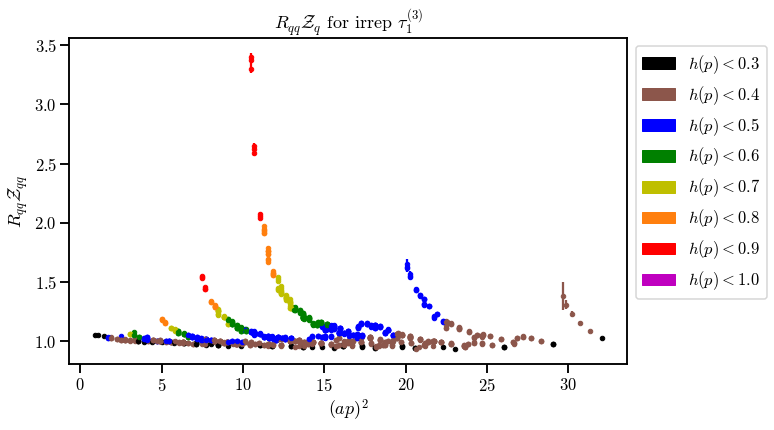

In [7]:
plot_h4_breaking(apsq_list, RqqZqq_mu[0], RqqZqq_sigma[0], r'$R_{qq}\mathcal{Z}_{qq}$', color_list, \
                 title = r'$R_{qq}\mathcal{Z}_q$ for irrep $\tau_1^{(3)}$')

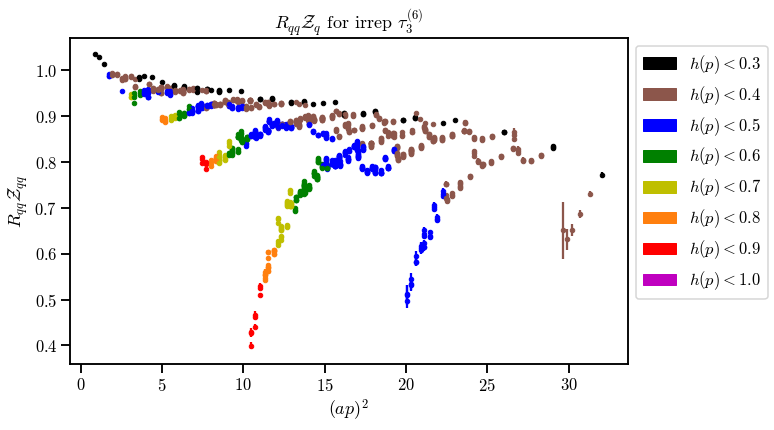

In [8]:
plot_h4_breaking(apsq_list, RqqZqq_mu[1], RqqZqq_sigma[1], r'$R_{qq}\mathcal{Z}_{qq}$', color_list, \
                 title = r'$R_{qq}\mathcal{Z}_q$ for irrep $\tau_3^{(6)}$')

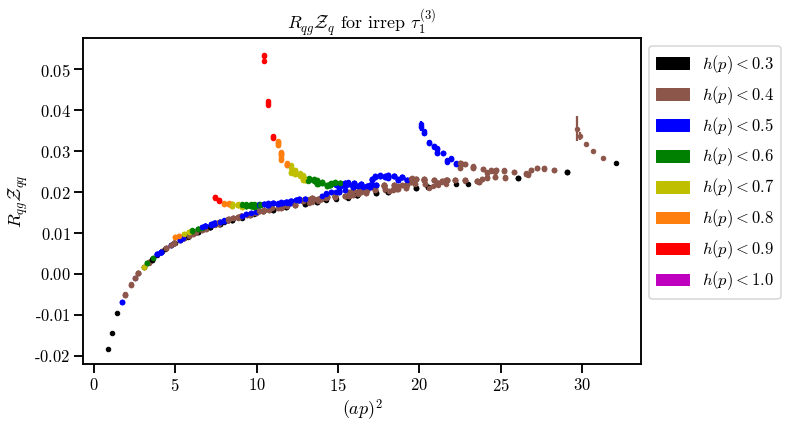

In [9]:
plot_h4_breaking(apsq_list, RqgZqq_mu[0], RqgZqq_sigma[0], r'$R_{qg}\mathcal{Z}_{qq}$', color_list, \
                 title = r'$R_{qg}\mathcal{Z}_q$ for irrep $\tau_1^{(3)}$')

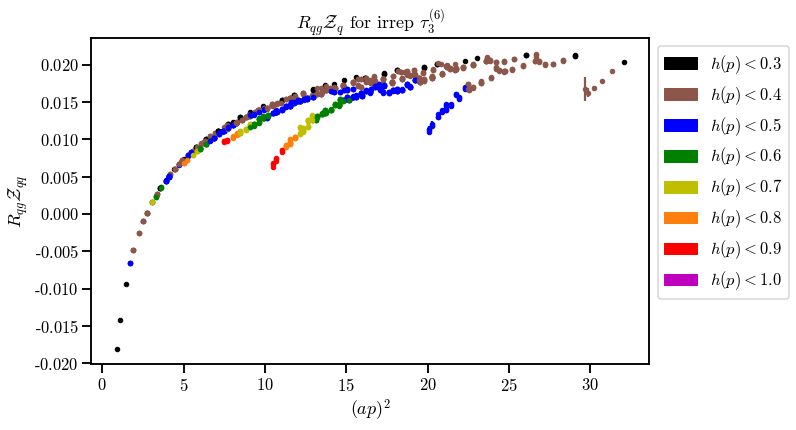

In [10]:
plot_h4_breaking(apsq_list, RqgZqq_mu[1], RqgZqq_sigma[1], r'$R_{qg}\mathcal{Z}_{qq}$', color_list, \
                 title = r'$R_{qg}\mathcal{Z}_q$ for irrep $\tau_3^{(6)}$')

### RCs with democracy $h\leq 0.35\equiv h_\mathrm{cut}$

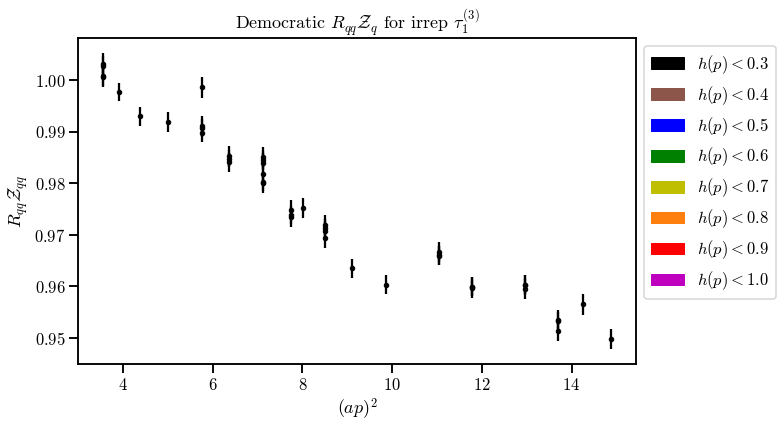

In [11]:
plot_h4_breaking(apsq_list_sub, RqqZqq_sub_mu[0], RqqZqq_sub_sigma[0], r'$R_{qq}\mathcal{Z}_{qq}$', color_list_sub, \
                 title = r'Democratic $R_{qq}\mathcal{Z}_q$ for irrep $\tau_1^{(3)}$')

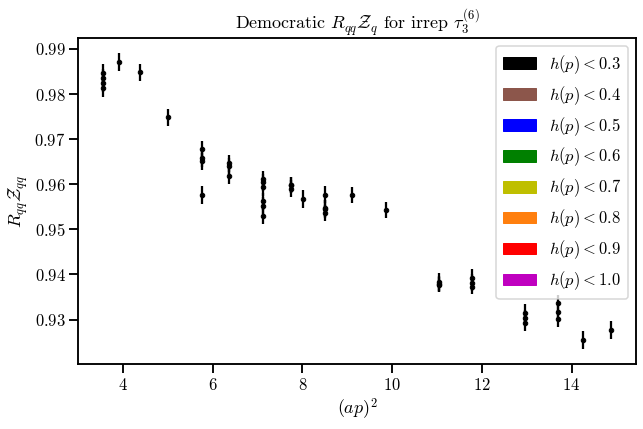

In [12]:
plot_h4_breaking(apsq_list_sub, RqqZqq_sub_mu[1], RqqZqq_sub_sigma[1], r'$R_{qq}\mathcal{Z}_{qq}$', color_list_sub, \
                 title = r'Democratic $R_{qq}\mathcal{Z}_q$ for irrep $\tau_3^{(6)}$')

### RCs with a uniform cut on $p^{[2n]}$, $n = 2, 3, 4, 5$

Can replot if we want (currently the same as the cells above)

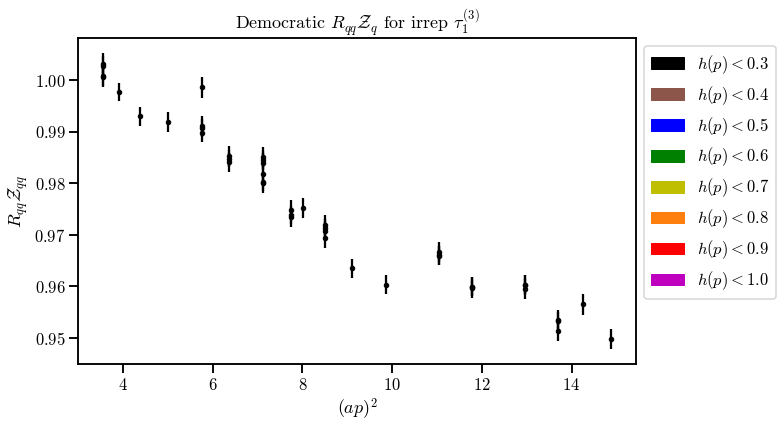

In [14]:
plot_h4_breaking(apsq_list_sub, RqqZqq_sub_mu[0], RqqZqq_sub_sigma[0], r'$R_{qq}\mathcal{Z}_{qq}$', color_list_sub, \
                 title = r'Democratic $R_{qq}\mathcal{Z}_q$ for irrep $\tau_1^{(3)}$')

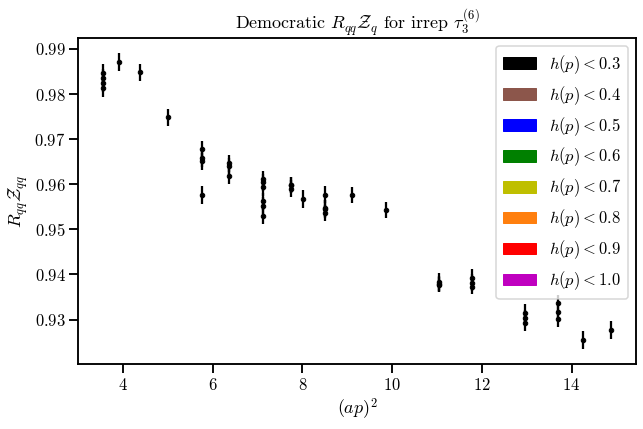

In [15]:
plot_h4_breaking(apsq_list_sub, RqqZqq_sub_mu[1], RqqZqq_sub_sigma[1], r'$R_{qq}\mathcal{Z}_{qq}$', color_list_sub, \
                 title = r'Democratic $R_{qq}\mathcal{Z}_q$ for irrep $\tau_3^{(6)}$')

## Perform the fits